# Prepare Environment
### Load Libraries and dependencies

In [1]:
import cudf
cudf.__version__

'24.02.02'

In [2]:
import cuml
cuml.__version__

'24.02.00'

In [3]:
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import gc
import pickle
import xgboost as xgb

#import dask_ml.model_selection as dcv
from sklearn.model_selection import GridSearchCV
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.model_selection import train_test_split
from cuml.metrics.accuracy import accuracy_score
from cuml.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, make_scorer, roc_curve, auc

import time
from contextlib import contextmanager

### Create Timer Function

In [4]:
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

### Silence Warning Prints

In [5]:
import warnings
warnings.filterwarnings("ignore")  # Reduce number of messages/warnings displayed

# Set GPU memory when restarting kernel

In [6]:
!nvidia-smi

Fri Apr 26 04:46:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
|  0%   32C    P2              99W / 420W |   2004MiB / 24576MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#Print GPU list
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4)
GPU 1: NVIDIA GeForce RTX 2060 SUPER (UUID: GPU-9234d598-4065-602a-8139-1b0b2bc70750)


In [8]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

CUDA available: True


In [9]:
#Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0" #select 3090

### Spin up CUDA Cluster

In [11]:
#Clear GPU memory on 'kernel reset and run all'
torch.cuda.empty_cache()
gc.collect()

197

In [10]:
#3090: GPU-f95b02b8-3c1a-8104-7eb1-25ec537b65e4
#2060S: GPU-9234d598-4065-602a-8139-1b0b2bc70750

cluster = LocalCUDACluster(protocol="ucx", #use ucx for inter-gpu training (RDMA, exclude cpu)
                           enable_tcp_over_ucx=None,
                           CUDA_VISIBLE_DEVICES= "0")
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 39.03 GiB
Status: running,Using processes: True
Comm: ucx://127.0.0.1:32857,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 39.03 GiB
Comm: ucx://127.0.0.1:42339,Total threads: 1
Dashboard: http://127.0.0.1:37445/status,Memory: 39.03 GiB
Nanny: ucx://127.0.0.1:37299,


# Load Dataset

In [12]:
#Read smote data back to nb ad cuda df
X_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_train_smote.parquet")
y_train = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_train_smote.parquet")['label']
X_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/X_test_smote.parquet")
y_test = pd.read_parquet(r"../../capstone_data/archive/SMOTE_train_test_split/y_test_smote.parquet")['label']

print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Define GridSearch and Model Parameters

In [13]:
N_FOLDS = 5
N_ITER = 25

In [14]:
## Initialize model
model_xgb = xgb.XGBClassifier(tree_method="gpu_hist")

#gridsearch will use these parameter values to find the best performing model
params_xgb = {
    "max_depth": np.arange(start=3, stop=15, step=4),  # Default = 6
    "alpha": np.logspace(-3, -1, 5),  # default = 0
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.15, 0.3],  # default = 0.3
    "min_child_weight": np.arange(start=2, stop=10, step=3),  # default = 1
    "n_estimators": [100, 200, 1000],
}

In [15]:
#converts the y label into a float32 type. This is because some cuML models only accept this data type
def accuracy_score_wrapper(y, y_hat):
    """
    A wrapper function to convert labels to float32,
    and pass it to accuracy_score.

    Params:
    - y: The y labels that need to be converted
    - y_hat: The predictions made by the model
    """
    y = y.astype("float32")  # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)


accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)


def do_HPO(model, gridsearch_params, scorer, X, y, mode="gpu-Grid", n_iter=10):
    """
    Perform HPO based on the mode specified

    mode: default gpu-Grid. The possible options are:
    1. gpu-grid: Perform GPU based GridSearchCV
    2. gpu-random: Perform GPU based RandomizedSearchCV

    n_iter: specified with Random option for number of parameter settings sampled

    Returns the best estimator and the results of the search
    """
    if mode == "gpu-grid":
        print("gpu-grid selected")
        clf = GridSearchCV(model, gridsearch_params, cv=N_FOLDS, scoring="f1", verbose=3)
    elif mode == "gpu-random":
        print("gpu-random selected")
        clf = GridSearchCV(
            model, gridsearch_params, cv=N_FOLDS, scoring="f1", n_iter=n_iter
        )

    else:
        print("Unknown Option, please choose one of [gpu-grid, gpu-random]")
        return None, None
    res = clf.fit(X, y)
    print(
        "Best clf and score {} {}\n---\n".format(res.best_estimator_, res.best_score_)
    )
    return res.best_estimator_, res


def print_acc(model, X_train, y_train, X_test, y_test, mode_str="Default"):
    """
    Trains a model on the train data provided, and prints the accuracy of the trained model.
    mode_str: User specifies what model it is to print the value
    """
    y_pred = model.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_pred, y_test.astype("float32"), convert_dtype=True)
    print("{} model accuracy: {}".format(mode_str, score))

In [16]:
#Coerce columns as necessary for cuML models
for col in X_train.columns:
    X_train[col] = X_train[col].astype("float32")
y_train = y_train.astype("int32")

for col in X_test.columns:
    X_test[col] = X_test[col].astype("float32")
y_test = y_test.astype("int32")

In [20]:
%%time
#Model training without hyperparameter tuning- trains in 22.4s - Default acc: 0.9999332427978516
# print(
#     "Default acc: ",
#     accuracy_score(model_xgb.fit(X_train, y_train).predict(X_test), y_test),
# )

Default acc:  0.9999332427978516
CPU times: user 35.8 s, sys: 1.64 s, total: 37.5 s
Wall time: 22.4 s


In [21]:
%%time
# XGB-gpu-grid time:  141239.88000
# Searched over 810 parameters
# CPU times: user 2d 6h 46min 30s, sys: 1h 34min 42s, total: 2d 8h 21min 13s
# Wall time: 1d 15h 13min 59s

# mode = "gpu-grid"

# with timed("XGB-" + mode):
#     res, results = do_HPO(
#         model_xgb,
#         params_xgb,
#         cuml_accuracy_scorer,
#         X_train,
#         y_train,
#         mode=mode,
#         n_iter=N_ITER,
#     )

# #Report Results for best model hyperparameters
# print("Searched over {} parameters".format(len(results.cv_results_["mean_test_score"])))

gpu-grid selected
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
[CV 1/5] END alpha=0.001, learning_rate=0.001, max_depth=3, min_child_weight=2, n_estimators=100;, score=0.997 total time=  19.6s
[CV 2/5] END alpha=0.001, learning_rate=0.001, max_depth=3, min_child_weight=2, n_estimators=100;, score=0.997 total time=  20.0s
[CV 3/5] END alpha=0.001, learning_rate=0.001, max_depth=3, min_child_weight=2, n_estimators=100;, score=0.997 total time=  18.3s
[CV 4/5] END alpha=0.001, learning_rate=0.001, max_depth=3, min_child_weight=2, n_estimators=100;, score=0.997 total time=  19.1s
[CV 5/5] END alpha=0.001, learning_rate=0.001, max_depth=3, min_child_weight=2, n_estimators=100;, score=0.997 total time=  18.9s
[CV 1/5] END alpha=0.001, learning_rate=0.001, max_depth=3, min_child_weight=2, n_estimators=200;, score=0.997 total time=  24.9s
[CV 2/5] END alpha=0.001, learning_rate=0.001, max_depth=3, min_child_weight=2, n_estimators=200;, score=0.997 total time=  26.7s
[CV 3/5]

In [22]:
#Get improved model accuracy - Improved acc:  0.9999722242355347
# print("Improved acc: ", accuracy_score(res.predict(X_test), y_test))

Improved acc:  0.9999722242355347


In [25]:
#Tabluate gridsearch results
# xgb_gridsearch_res_df = pd.concat([pd.DataFrame(results.cv_results_["params"]),pd.DataFrame(results.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
# xgb_gridsearch_res_df.to_csv('trained_models/xgb_gridsearch_res.csv', index=False)

# xgb_gridsearch_res_df

,alpha,learning_rate,max_depth,min_child_weight,n_estimators,Accuracy
0,0.001,0.001,3,2,100,0.996554
1,0.001,0.001,3,2,200,0.996554
2,0.001,0.001,3,2,1000,0.996554
3,0.001,0.001,3,5,100,0.996554
4,0.001,0.001,3,5,200,0.996554
...,...,...,...,...,...,...
805,0.100,0.300,11,5,200,0.999926
806,0.100,0.300,11,5,1000,0.999956
807,0.100,0.300,11,8,100,0.999921
808,0.100,0.300,11,8,200,0.999921


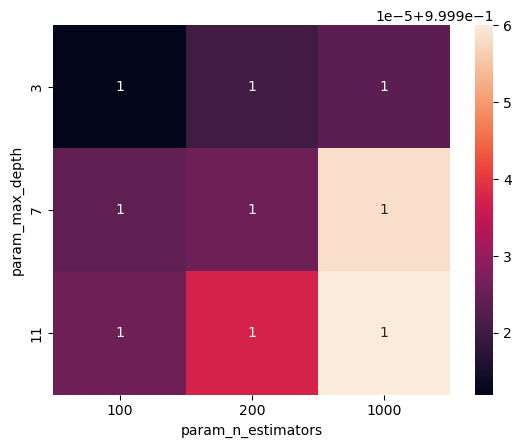

In [26]:
# from cuml.experimental.hyperopt_utils import plotting_utils
# df_gridsearch = pd.DataFrame(results.cv_results_)
# plotting_utils.plot_heatmap(df_gridsearch, "param_max_depth", "param_n_estimators")

In [27]:
# {'alpha': 0.03162277660168379,
 # 'learning_rate': 0.3,
 # 'max_depth': 11,
 # 'min_child_weight': 2,
 # 'n_estimators': 1000}
# results.best_params_

{'alpha': 0.03162277660168379,
 'learning_rate': 0.3,
 'max_depth': 11,
 'min_child_weight': 2,
 'n_estimators': 1000}

# Train and Test with Official Parameters

In [17]:
best_params_xgbmodel = xgb.XGBClassifier(tree_method="gpu_hist",
                                         alpha = 0.03162277660168379,
                                         learning_rate= 0.3,
                                         max_depth=11, 
                                         min_child_weight= 2,
                                         n_estimators=1000)

In [18]:
%%time
#Executes in 1min
# Fit the model to the training data
model = best_params_xgbmodel.fit(X_train, y_train)

CPU times: user 1min 6s, sys: 162 ms, total: 1min 7s
Wall time: 53 s


In [19]:
# %%time
# #Executes in 1min and 9sec
# # Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate Model

In [23]:
#load model if already trained
filename = '../trained_models/cuXGB_model_HPO_9999accuracy.pkl'

with open(filename, 'rb') as file:
    model = pickle.load(file)

y_pred = model.predict(X_test)

In [20]:
#Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9999722242355347
Precision: 0.9999722093242278
Recall: 0.9999722114742897
F1 Score: 0.9999722100671937


### Confusion Matrix

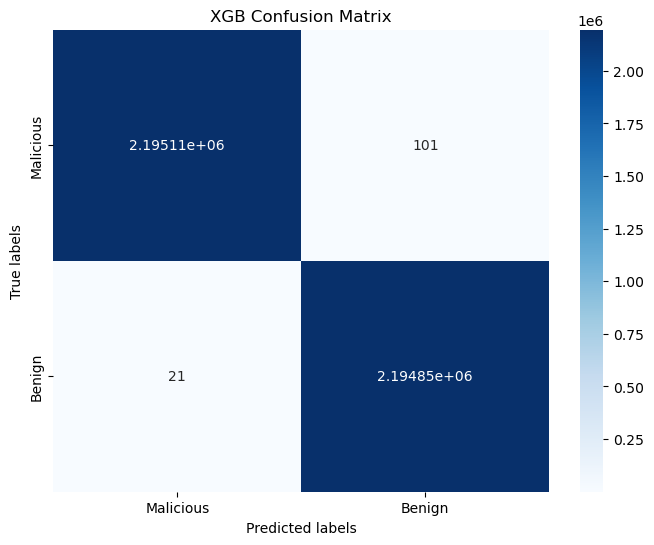

In [29]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Malicious', 'Benign'], yticklabels=['Malicious', 'Benign'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('XGB Confusion Matrix')
plt.savefig('../../Graphs/Conf_Mat/XGB_HPO_CM_alpha0.03162277660168379_learningrate03_maxdepth11_minchildweight2_nestimators1000.png')
plt.show()

### ROC Curve

In [22]:
y_probs = model.predict_proba(X_test)
#y_probs[:5]

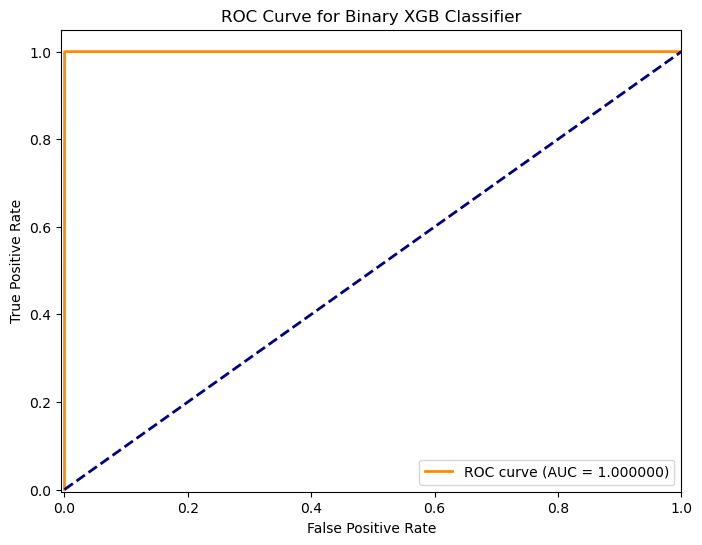

In [42]:
#Calculate prediction performance metrics
fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.005, 1.0])
plt.ylim([-0.005, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary XGB Classifier')
plt.legend(loc="lower right")
plt.savefig('../../Graphs/ROC_CUR/XGB_HPO_ROC_alpha003162277660168379_learningrate03_maxdepth11_minchildweight2_nestimators1000.png')
plt.show()

# Saving Trained Model

In [37]:
# # Save the trained model using pickle
# model_filename = 'trained_models/cuXGB_model_HPO_9999accuracy.pkl'
# with open(model_filename, 'wb') as file:
#     pickle.dump(model, file)